<a href="https://colab.research.google.com/github/thevinudassanayake/ML-Cousework-telco-churn-project-/blob/main/Telco_Churn_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Reproducibility
import os
import random
import numpy as np
import tensorflow as tf

os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay
)
from sklearn.utils.class_weight import compute_class_weight

# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [4]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [5]:
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

print("\nInvalid tenure values:", (df["tenure"] < 0).sum())
print("Invalid MonthlyCharges:", (df["MonthlyCharges"] <= 0).sum())

print("\nSample TotalCharges values:")
print(df["TotalCharges"].head())

print("\nTarget distribution:")
print(df["Churn"].value_counts(normalize=True))


Dataset shape: (7043, 21)

Data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract  

In [6]:
# Remove non-informative identifier
df.drop("customerID", axis=1, inplace=True)

# Fix TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Encode target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


/tmp/ipython-input-2190220526.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


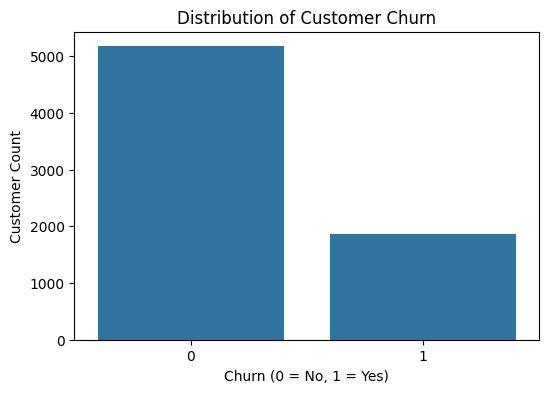

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df)
plt.title("Distribution of Customer Churn")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Customer Count")

plt.savefig("figure_1_churn_distribution.png", bbox_inches="tight")
plt.show()


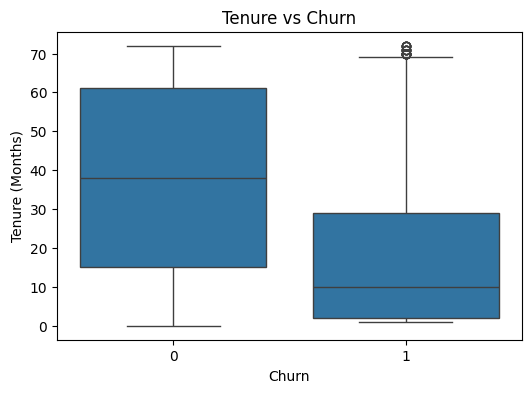

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.xlabel("Churn")
plt.ylabel("Tenure (Months)")

plt.savefig("figure_2_tenure_vs_churn.png", bbox_inches="tight")
plt.show()


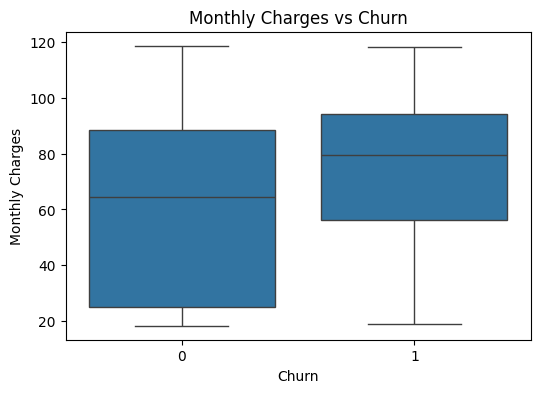

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")

plt.savefig("figure_3_monthlycharges_vs_churn.png", bbox_inches="tight")
plt.show()


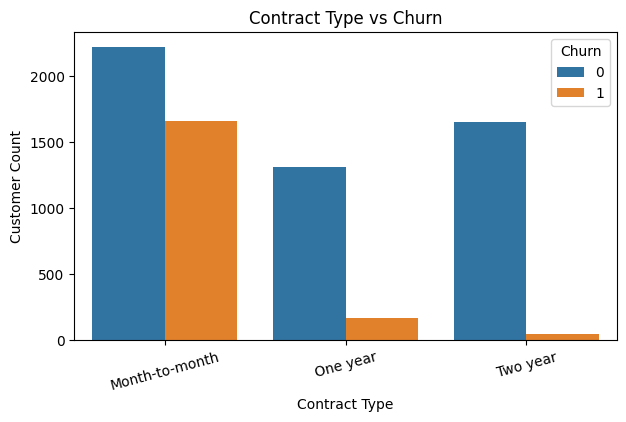

In [10]:
plt.figure(figsize=(7,4))
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract Type vs Churn")
plt.xlabel("Contract Type")
plt.ylabel("Customer Count")
plt.xticks(rotation=15)

plt.savefig("figure_4_contract_vs_churn.png", bbox_inches="tight")
plt.show()


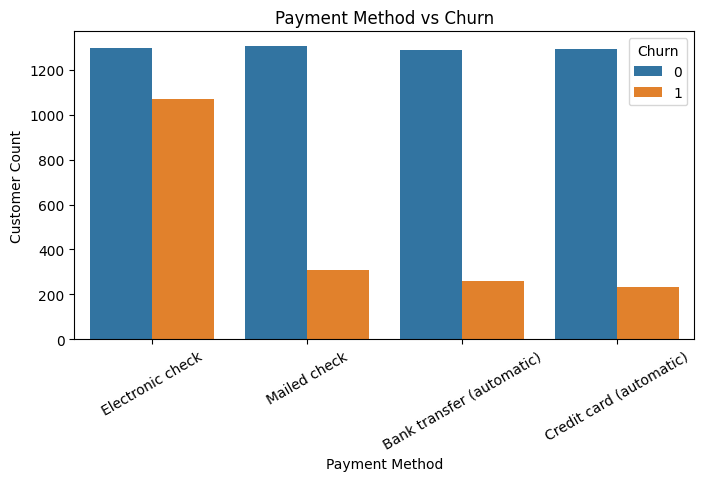

In [11]:
plt.figure(figsize=(8,4))
sns.countplot(x="PaymentMethod", hue="Churn", data=df)
plt.title("Payment Method vs Churn")
plt.xlabel("Payment Method")
plt.ylabel("Customer Count")
plt.xticks(rotation=30)

plt.savefig("figure_5_paymentmethod_vs_churn.png", bbox_inches="tight")
plt.show()


In [12]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


In [15]:
dt_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__class_weight": [None, "balanced"]
}


dt_grid = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_


Decision Tree Results: {'Accuracy': 0.7537260468417317, 'Precision': 0.525328330206379, 'Recall': 0.7486631016042781, 'F1': 0.61742006615215, 'ROC_AUC': np.float64(0.8370521067452014)}
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.77      1409



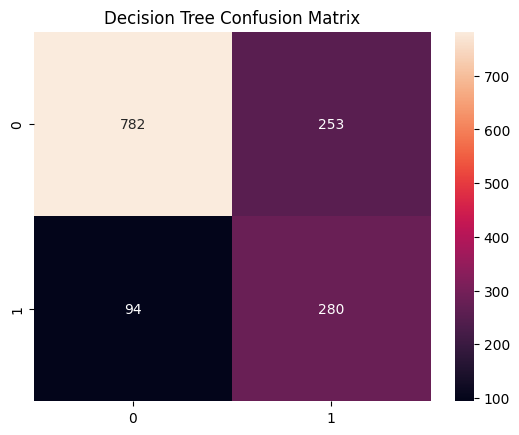

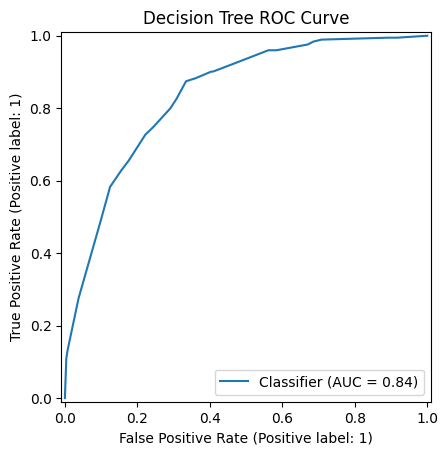

In [16]:
y_dt_pred = dt_best.predict(X_test)
y_dt_prob = dt_best.predict_proba(X_test)[:, 1]

dt_results = {
    "Accuracy": accuracy_score(y_test, y_dt_pred),
    "Precision": precision_score(y_test, y_dt_pred),
    "Recall": recall_score(y_test, y_dt_pred),
    "F1": f1_score(y_test, y_dt_pred),
    "ROC_AUC": roc_auc_score(y_test, y_dt_prob)
}

print("Decision Tree Results:", dt_results)
print(classification_report(y_test, y_dt_pred))

sns.heatmap(confusion_matrix(y_test, y_dt_pred), annot=True, fmt="d")
plt.title("Decision Tree Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_dt_prob)
plt.title("Decision Tree ROC Curve")
plt.show()


In [17]:
X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn = preprocessor.transform(X_test)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


In [18]:
nn_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_nn.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

nn_model.fit(
    X_train_nn,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7241 - loss: 0.5685 - val_accuracy: 0.7036 - val_loss: 0.5834
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7538 - loss: 0.4818 - val_accuracy: 0.6965 - val_loss: 0.5855
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7553 - loss: 0.4770 - val_accuracy: 0.6974 - val_loss: 0.5865
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 0.4735 - val_accuracy: 0.6957 - val_loss: 0.5887
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7601 - loss: 0.4710 - val_accuracy: 0.6930 - val_loss: 0.5913
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7595 - loss: 0.4685 - val_accuracy: 0.6948 - val_loss: 0.5909


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Neural Network Results: {'Accuracy': 0.7146912704045423, 'Precision': 0.4783950617283951, 'Recall': 0.8288770053475936, 'F1': 0.6066536203522505, 'ROC_AUC': np.float64(0.831147795086414)}
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1035
           1       0.48      0.83      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.71      0.73      1409



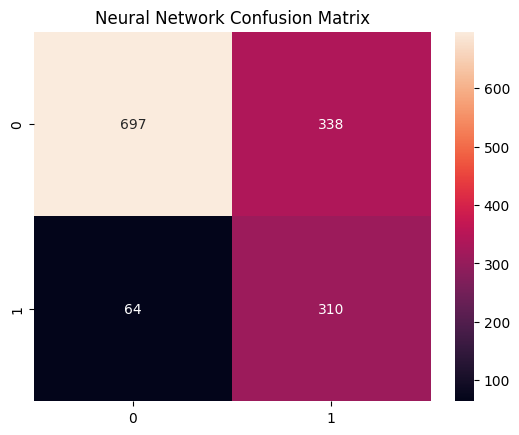

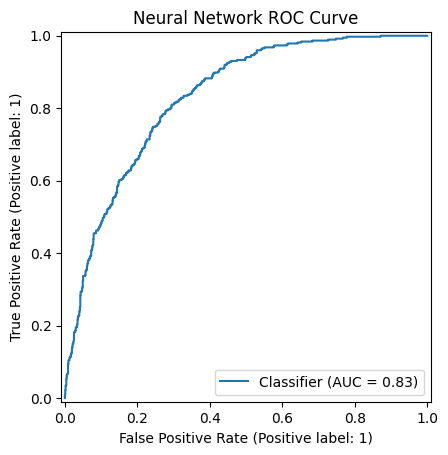

In [19]:
y_nn_prob = nn_model.predict(X_test_nn).ravel()
y_nn_pred = (y_nn_prob >= 0.5).astype(int)

nn_results = {
    "Accuracy": accuracy_score(y_test, y_nn_pred),
    "Precision": precision_score(y_test, y_nn_pred),
    "Recall": recall_score(y_test, y_nn_pred),
    "F1": f1_score(y_test, y_nn_pred),
    "ROC_AUC": roc_auc_score(y_test, y_nn_prob)
}

print("Neural Network Results:", nn_results)
print(classification_report(y_test, y_nn_pred))

sns.heatmap(confusion_matrix(y_test, y_nn_pred), annot=True, fmt="d")
plt.title("Neural Network Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_nn_prob)
plt.title("Neural Network ROC Curve")
plt.show()


In [20]:
comparison_df = pd.DataFrame(
    [dt_results, nn_results],
    index=["Decision Tree", "Neural Network"]
)

comparison_df


,Accuracy,Precision,Recall,F1,ROC_AUC
Decision Tree,0.753726,0.525328,0.748663,0.617420,0.837052
Neural Network,0.714691,0.478395,0.828877,0.606654,0.831148
